# Sommelier inteligente

## Visão geral e objetivos

A objetivo da aplicação é gerar um modelo e aplicação em aprendizado de máquina denominada Sommelier Inteligente que automaticamente reconheça um determinado tipo de vinho considerando os conjunto de dados no repositório: https://archive.ics.uci.edu/ml/datasets/wine

In [1]:
import joblib
import os
import urllib

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

print('Matplot version : {}'.format(matplotlib.__version__))
print('Numpy version : {}'.format(np.__version__))
print('Pandas version : {}'.format(pd.__version__))
print('Sklearn version : {}'.format(sklearn.__version__))

WINE_ROOT = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/'
WINE_URL  = WINE_ROOT + 'wine.data'

DATA_PATH = os.path.join('..', 'data', 'raw')
DATA_FILE = 'wine.csv'
WINE_DATA = os.path.join(DATA_PATH, DATA_FILE)

DEPLOY_PATH = os.path.join('..', '', 'model')
DEPLOY_FILE = 'finalized_model.sav'
#DEPLOY_FILE = datetime.now().strftime("%Y%m%d_%H%M%S") + '_finalized_model.sav'


Matplot version : 3.3.2
Numpy version : 1.19.2
Pandas version : 1.1.3
Sklearn version : 0.23.2


#  Passo 2. Recuperação dos dados

In [2]:
def download_data(data_url, data_path, data_file):
    os.makedirs(data_path, exist_ok=True)
    local_path = os.path.join(data_path, data_file)
    urllib.request.urlretrieve(data_url, local_path)

In [3]:
download_data(WINE_URL, DATA_PATH, DATA_FILE)

In [4]:
def load_data(data_path, data_file):
    local_path = os.path.join(data_path, data_file)
    return pd.read_csv(local_path, header=None, names=['Classe','Álcool','Ácido málico','Cinza',
                                                       'Alcalinidade das cinzas','Magnésio','Fenóis totais',
                                                       'Flavanóides','Fenóis não flavanoides',
                                                       'Proantocianinas','Intensidade da cor',
                                                       'Matiz','OD280/OD315',
                                                       'Proline'])

In [5]:
wine_data = load_data(DATA_PATH, DATA_FILE)

# Passo 3. Análise Exploratória de Dados

In [6]:
wine_data.head()

Classe  Álcool  Ácido málico  Cinza  Alcalinidade das cinzas  Magnésio  \
0       1   14.23          1.71   2.43                     15.6       127   
1       1   13.20          1.78   2.14                     11.2       100   
2       1   13.16          2.36   2.67                     18.6       101   
3       1   14.37          1.95   2.50                     16.8       113   
4       1   13.24          2.59   2.87                     21.0       118   

   Fenóis totais  Flavanóides  Fenóis não flavanoides  Proantocianinas  \
0           2.80         3.06                    0.28             2.29   
1           2.65         2.76                    0.26             1.28   
2           2.80         3.24                    0.30             2.81   
3           3.85         3.49                    0.24             2.18   
4           2.80         2.69                    0.39             1.82   

   Intensidade da cor  Matiz  OD280/OD315  Proline  
0                5.64   1.04         3.92     1065  
1                4.38   1.05         3.40     1050  
2                5.68   1.03         3.17     1185  
3                7.80   0.86         3.45     1480  
4                4.32   1.04         2.93      735

In [7]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Classe                   178 non-null    int64  
 1   Álcool                   178 non-null    float64
 2   Ácido málico             178 non-null    float64
 3   Cinza                    178 non-null    float64
 4   Alcalinidade das cinzas  178 non-null    float64
 5   Magnésio                 178 non-null    int64  
 6   Fenóis totais            178 non-null    float64
 7   Flavanóides              178 non-null    float64
 8   Fenóis não flavanoides   178 non-null    float64
 9   Proantocianinas          178 non-null    float64
 10  Intensidade da cor       178 non-null    float64
 11  Matiz                    178 non-null    float64
 12  OD280/OD315              178 non-null    float64
 13  Proline                  178 non-null    int64  
dtypes: float64(11), int64(3)
m

In [8]:
wine_data.describe()

Classe      Álcool  Ácido málico       Cinza  \
count  178.000000  178.000000    178.000000  178.000000   
mean     1.938202   13.000618      2.336348    2.366517   
std      0.775035    0.811827      1.117146    0.274344   
min      1.000000   11.030000      0.740000    1.360000   
25%      1.000000   12.362500      1.602500    2.210000   
50%      2.000000   13.050000      1.865000    2.360000   
75%      3.000000   13.677500      3.082500    2.557500   
max      3.000000   14.830000      5.800000    3.230000   

       Alcalinidade das cinzas    Magnésio  Fenóis totais  Flavanóides  \
count               178.000000  178.000000     178.000000   178.000000   
mean                 19.494944   99.741573       2.295112     2.029270   
std                   3.339564   14.282484       0.625851     0.998859   
min                  10.600000   70.000000       0.980000     0.340000   
25%                  17.200000   88.000000       1.742500     1.205000   
50%                  19.500000   98.000000       2.355000     2.135000   
75%                  21.500000  107.000000       2.800000     2.875000   
max                  30.000000  162.000000       3.880000     5.080000   

       Fenóis não flavanoides  Proantocianinas  Intensidade da cor  \
count              178.000000       178.000000          178.000000   
mean                 0.361854         1.590899            5.058090   
std                  0.124453         0.572359            2.318286   
min                  0.130000         0.410000            1.280000   
25%                  0.270000         1.250000            3.220000   
50%                  0.340000         1.555000            4.690000   
75%                  0.437500         1.950000            6.200000   
max                  0.660000         3.580000           13.000000   

            Matiz  OD280/OD315      Proline  
count  178.000000   178.000000   178.000000  
mean     0.957449     2.611685   746.893258  
std      0.228572     0.709990   314.907474  
min      0.480000     1.270000   278.000000  
25%      0.782500     1.937500   500.500000  
50%      0.965000     2.780000   673.500000  
75%      1.120000     3.170000   985.000000  
max      1.710000     4.000000  1680.000000

# Correlação e distribuição

In [62]:
X = wine_data[['Álcool','Ácido málico','Cinza','Alcalinidade das cinzas','Magnésio','Fenóis totais',
               'Flavanóides','Fenóis não flavanoides','Proantocianinas','Intensidade da cor',
               'Matiz','OD280/OD315']]
y = wine_data['Classe']

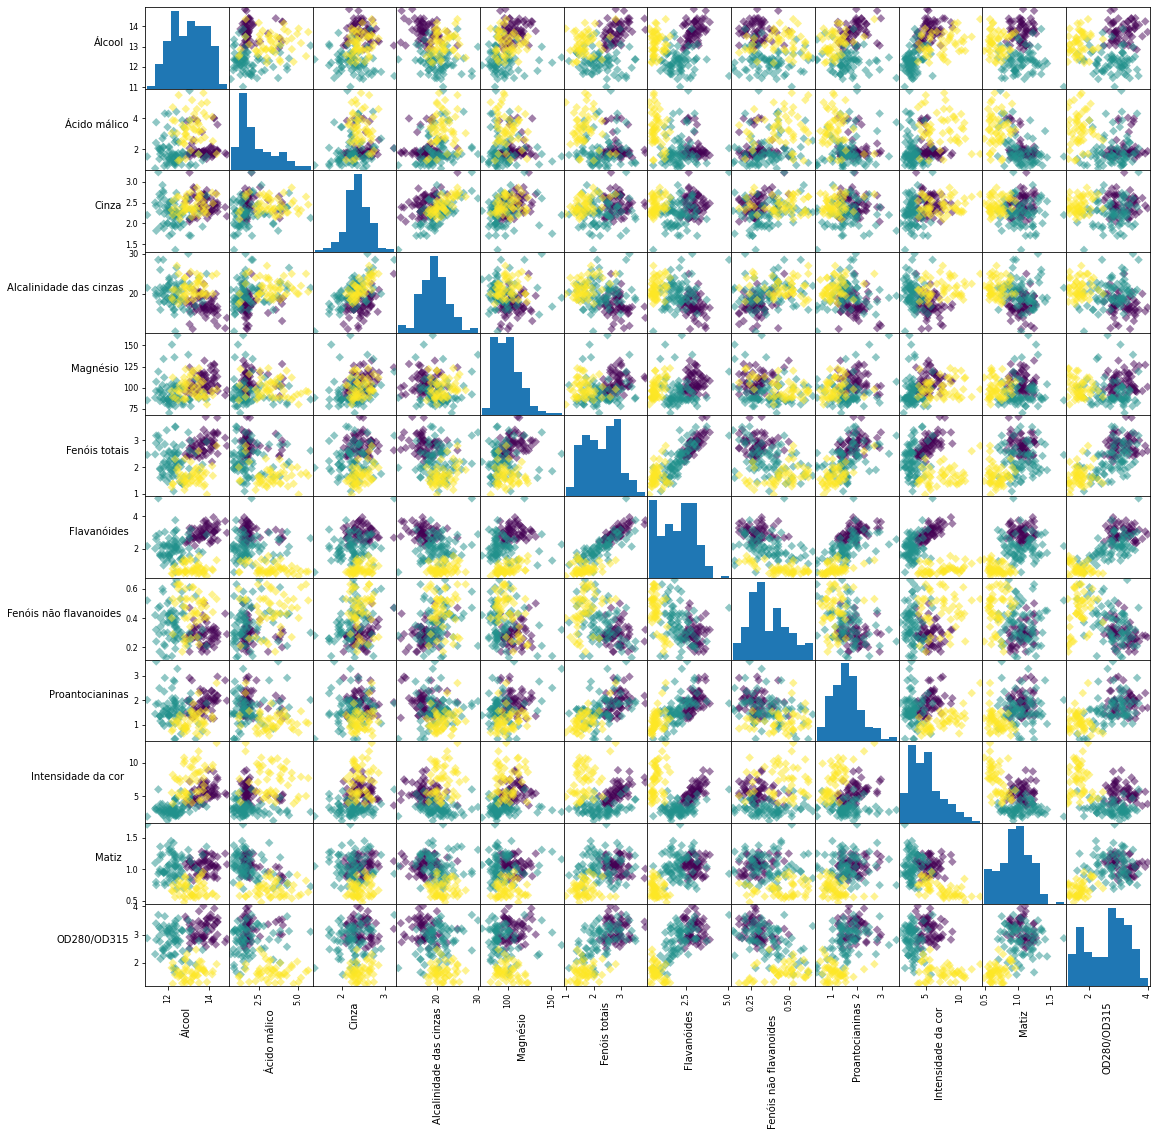

In [63]:
cores = y.astype('category').cat.codes
_ = pd.plotting.scatter_matrix(X, c=cores, figsize=[18, 18], marker='D')

for ax in _.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

In [64]:
print(y.astype)


<bound method NDFrame.astype of 0      1
1      1
2      1
3      1
4      1
      ..
173    3
174    3
175    3
176    3
177    3
Name: Classe, Length: 178, dtype: int64>


# Passo 4: Treinamento do Modelo

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=42)

In [66]:
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy  = np.empty(len(neighbors))
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i]  = knn.score(X_test, y_test)

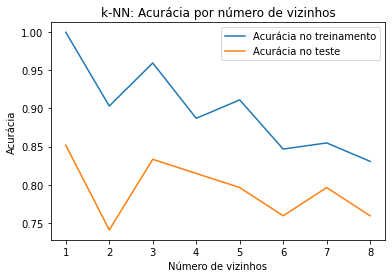

In [67]:
plt.title('k-NN: Acurácia por número de vizinhos')
plt.plot(neighbors, train_accuracy, label='Acurácia no treinamento')
plt.plot(neighbors, test_accuracy, label='Acurácia no teste')
plt.legend()
plt.xlabel('Número de vizinhos')
plt.ylabel('Acurácia')
plt.show()

In [68]:
model = KNeighborsClassifier(n_neighbors=6)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6)

# Passo 5: Testar o modelo

In [69]:
predicoes = model.predict(X_test)
print('Predições: {}'.format(predicoes))
[['1']][0]

Predições: [1 1 1 1 1 1 3 2 1 1 2 2 3 2 1 3 2 1 1 3 2 1 3 3 1 3 2 1 1 1 1 2 2 2 2 3 1
 2 1 1 3 1 1 1 1 2 2 1 3 1 1 2 3 1]


['1']

In [70]:
acuracia = model.score(X_test, y_test)
print("Acurácia do model: {}".format(acuracia))

Acurácia do model: 0.7592592592592593


# Passo 6. Deploy do modelo

In [71]:
local_path = os.path.join(DEPLOY_PATH, DEPLOY_FILE)
joblib.dump(model, local_path)

['..\\model\\finalized_model.sav']